### Linear regressions with regularization: 
## Ridge and the Lasso

In [3]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import scale 
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, Lasso, LassoCV
from sklearn.metrics import mean_squared_error

We will now try some alternative linear regressions: Ridge and Lasso regression. Just like OLS, they result in a linear fit to the data:

$y = \text{intercept} + \text{coef}[0] \cdot \text{height} + \text{coef}[1]\cdot \text{weight}$.

The only difference is that Ridge and Lasso has an in-built "regularization", which means they search for a balance between a good $R^2$ value and small coefficients. 

Note that it is important to scale your features when you use Ridge or Lasso (whereas it has no effect on the performance of an OLS regressor). But we don't have to do it as part of pre-processing - we can simply use the "normalize"-argument when we initialize the regressors. 

In [4]:
data = pd.read_csv('500_Person_Gender_Height_Weight_Index.csv')
X = data.loc[:,'Gender':'Weight']
y = data['Index']

X = pd.get_dummies(X)
X
data

,Gender,Height,Weight,Index
0,Male,174,96,4
1,Male,189,87,2
2,Female,185,110,4
3,Female,195,104,3
4,Male,149,61,3
...,...,...,...,...
495,Female,150,153,5
496,Female,184,121,4
497,Female,141,136,5
498,Male,150,95,5


In [3]:
X_train, X_test , y_train, y_test = train_test_split(X, y, random_state=1)

# Ridge Regression
The `Ridge()` function has an alpha argument that is used to tune the model. We'll generate an array of alpha values ranging from very small to very big, essentially covering the full range of scenarios from the null model containing only the intercept, to the least squares fit:

In [4]:
alphas = 10**np.linspace(-10, 10, 100)

Associated with each alpha value is a vector of ridge regression coefficients, which we'll
store in a matrix `coefs`. In this case, it is a $4 \times 100$
matrix, with 4 rows (one for each predictor) and 100
columns (one for each value of alpha). 

In [5]:
ridge = Ridge() # normalize parameter deprecated. Using make_pipeline(StandardScaler(with_mean=False) is suggested
coefs = []

for a in alphas:
    ridge.set_params(alpha = a)
    ridge.fit(X, y)
    coefs.append(ridge.coef_)
    
np.shape(coefs)
height_coefficients = [coef[0] for coef in coefs]
weight_coefficients = [coef[1] for coef in coefs]
gender_female_coefficients = [coef[2] for coef in coefs]
gender_male_coefficients = [coef[3] for coef in coefs]

We expect the coefficient estimates to be much smaller, when a large value of alpha is used, as compared to when a small value of alpha is used. Let's plot and find out:

Text(0, 0.5, 'weights')

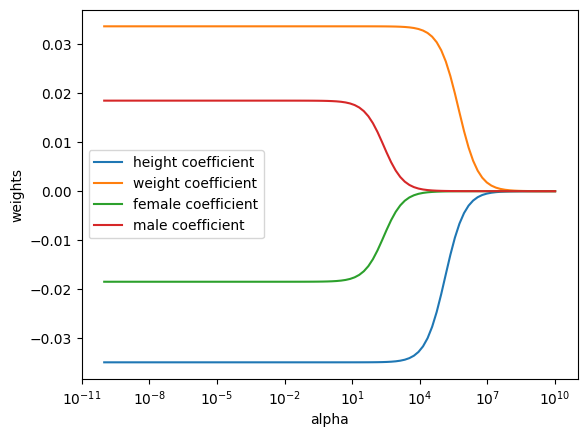

In [6]:
ax = plt.gca()
ax.set_xscale('log')
ax.plot(alphas, height_coefficients, label="height coefficient")
ax.plot(alphas, weight_coefficients, label="weight coefficient")
ax.plot(alphas, gender_female_coefficients, label="female coefficient")
ax.plot(alphas, gender_male_coefficients, label="male coefficient")
plt.legend()
plt.axis('tight')
plt.xlabel('alpha')
plt.ylabel('weights')

Let's compare the performance of the ridge regression for a few different values of alpha:

In [8]:
for alpha in [alphas[0], alphas[50], alphas[-1]]:
    ridge = Ridge(alpha=alpha)
    ridge.fit(X_train, y_train)
    print("alpha = {}".format(alpha))
    print("R^2 on train data is {} and on test data is {}".format(ridge.score(X_train, y_train), 
                                                              ridge.score(X_test,y_test)))
    print("")
    

alpha = 1e-10
R^2 on train data is 0.8276198012652942 and on test data is 0.818596598951614

alpha = 1.2618568830660184
R^2 on train data is 0.8276197965128979 and on test data is 0.8185954985681713

alpha = 10000000000.0
R^2 on train data is 5.263836403768263e-05 and on test data is -0.003523909324997021



### Using cross validation to find the best value for alpha

We can use cross-validation to choose the best value of alpha. We can do this using
the cross-validated ridge regression function, `RidgeCV()`.

In [9]:
ridgecv = RidgeCV(alphas = alphas)
ridgecv.fit(X_train, y_train)
ridgecv.alpha_

1353.0477745798075

The $R^2$ corresponding to this value for alpha are:

In [10]:
print("R^2 on train data is {} and on test data is {}".format(ridgecv.score(X_train, y_train), 
                                                              ridgecv.score(X_test,y_test)))

R^2 on train data is 0.8274955116945747 and on test data is 0.8193886808687796


and the coefficients associated with this value of alpha are:

In [11]:
ridgecv.coef_

array([-0.03597704,  0.03409105, -0.00175092,  0.00175092])

As expected, none of the coefficients are exactly zero - ridge regression does not
perform variable selection!

# The Lasso
In order to fit a lasso model, we'll
use the `Lasso()` function; however, this time we'll need to include the argument `max_iter = 10000`. Other than that change, we proceed just as we did in fitting a ridge model:

In [12]:
lasso = Lasso(max_iter = 10000) # normalize parameter deprecated. Using make_pipeline(StandardScaler(with_mean=False) is suggested
coefs = []

for a in alphas:
    lasso.set_params(alpha = a)
    lasso.fit(X_train, y_train)
    coefs.append(lasso.coef_)
    
np.shape(coefs)
height_coefficients = [coef[0] for coef in coefs]
weight_coefficients = [coef[1] for coef in coefs]
gender_female_coefficients = [coef[2] for coef in coefs]
gender_male_coefficients = [coef[3] for coef in coefs]

Text(0, 0.5, 'weights')

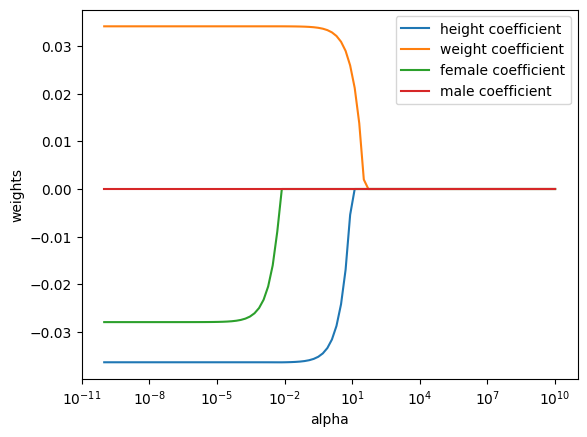

In [13]:
ax = plt.gca()
ax.set_xscale('log')
ax.plot(alphas, height_coefficients, label="height coefficient")
ax.plot(alphas, weight_coefficients, label="weight coefficient")
ax.plot(alphas, gender_female_coefficients, label="female coefficient")
ax.plot(alphas, gender_male_coefficients, label="male coefficient")
plt.legend()
plt.axis('tight')
plt.xlabel('alpha')
plt.ylabel('weights')

Notice that in the coefficient plot that depending on the choice of tuning
parameter, some of the coefficients are exactly equal to zero. We now
perform 10-fold cross-validation to choose the best alpha, refit the model, and compute the associated test error:

In [14]:
lassocv = LassoCV(alphas = None, cv = 10, max_iter = 100000)
lassocv.fit(X_train, y_train)

lasso.set_params(alpha=lassocv.alpha_)
lasso.fit(X_train, y_train)

Lasso(alpha=0.03478801066666667, max_iter=10000)

Lets see what the best performance is using the Lasso:

In [15]:
print("R^2 on train data is {} and on test data is {}".format(lassocv.score(X_train, y_train), 
                                                              lassocv.score(X_test,y_test)))

R^2 on train data is 0.8275107657656788 and on test data is 0.8184800629546126


This is a tiny bit worse than the best performance obtain using ridge regression. However, the lasso has a substantial advantage over ridge regression in that the resulting coefficient estimates are sparse! In addition to saving ressorces, this also makes the resulting model easier to interpret.

In [22]:
# Some of the coefficients are now reduced to exactly zero.
pd.Series(lasso.coef_, index=X.columns)

Height          -0.036345
Weight           0.034182
Gender_Female   -0.000000
Gender_Male      0.000000
dtype: float64